# Hungarian Multi Rings

**Goal:** In the past notebooks
- `SA-mini`
- `SA-warm-up`

I've been focusing on a single ring to stay in a good range for the hyperparameters.

But _now_ I still need to diagnose how to translate the (official) TensorFlow implementation of the Hungarian Loss to Pytorch.

Fortunately, the (concurrent work) DETR (End-to-End Object **DE**tection with **TR**ansformers) has an [implementation](https://www.kaggle.com/code/virajbagal/pytorch-starter-detection-transformer-train) of the Hungarian loss in Pytorch, using the same `scipy.optimize.linear_map_` function.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn.functional as F

# import os
# os.sys.path.append('code')
# from data import gen_events # Florian's ring generation script

'''
Remember -- Flo's rings generation script already adds up 
all of the ring energies, and I think having this at truth level 
would be quite nice.
'''

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Inputs:**

I want a minimal example to _show_ that this is working so I'll make the masks and have the prediction:

1. perturb the images by some noise
2. Have the background slots just be 0.


In [2]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

stdlow = 0.01
stdhigh = 0.05

bins = np.arange(xlow,xhigh,binWidth)

nBins = len(bins)-1

In [131]:
def make_batch(
    bins,
    N_events = 100000,
    N_clusters = 1,
    mean_var_cluster = np.log(0.001),
    sigma_var_cluster = 0.1,
    mean_lam_cluster = np.log(200.),
    sigma_lam_cluster = 1.,
    isRing=True,
    blurImage=False,
    xlow=-.5,
    xhigh=0.5,
    stdlow=0.01,
    stdhigh=0.05,
    device='cpu'
):
    '''
    Starts from Florian's `gen_events` function
    https://gitlab.lrz.de/neural_network_clustering/permutation_invariant_loss/-/blob/main/test_blur.ipynb
    
    But I wanted to return the occupancy maps that you multiply the OG image by to output partitioning
    of the image into the OG ring signals.
    '''

    eventHistograms = np.zeros(shape=(N_events, len(bins)-1, len(bins)-1,1) ) 
    
    eventMasks = np.zeros(shape=(N_events, N_clusters, len(bins)-1, len(bins)-1) ) 
    
    eventNumbers = np.zeros(N_events)

    nMaxClusters = N_clusters   
    
    eventInfo = np.zeros(shape=(N_events, nMaxClusters, 3))
    
    for iEvent in range(N_events):
        
        image = np.zeros_like(eventHistograms[iEvent,:,:,0])
        
        n_clusters = nMaxClusters

        eventNumbers[iEvent] += n_clusters
        eI = []
        
        for iCluster in range(min(n_clusters,nMaxClusters)):
            
            # how many events in this cluster
            lam_N_events_in_cluster = 200. 
            
            N_events_in_cluster = np.random.poisson(lam_N_events_in_cluster)

            # where is the cluster center
            cluster_center = np.random.uniform(low=xlow, high=xhigh, size=2)

            # what is the cluster spread
            var_cluster = np.random.uniform(stdlow,stdhigh) 
            
            cluster_events_x0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)
            cluster_events_y0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)

            if isRing:
                fact = np.sqrt(var_cluster/(cluster_events_x0**2+cluster_events_y0**2))
            else:
                fact = np.sqrt(var_cluster)

            cluster_events_x = cluster_events_x0*fact + cluster_center[0]
            cluster_events_y = cluster_events_y0*fact + cluster_center[1]
            
            # bin the events
            H, _, _ = np.histogram2d(cluster_events_x, cluster_events_y, bins=[bins,bins])

            eventMasks[iEvent,iCluster] = H.T
            image += H.T
                        
            eI.append(np.concatenate([cluster_center, [var_cluster]]))

        eventHistograms[iEvent,:,:,0] = np.copy(image)

        eventInfo[iEvent] = np.array(eI)
    
    # reshape eventHistograms
    eventHistograms = eventHistograms[:,None,:,:,0] # shape (bs, 1, nPixels, nPixels)
    
    eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
    
    return torch.FloatTensor(eventInfo).to(device), \
           torch.FloatTensor(eventHistograms).to(device), \
           torch.FloatTensor(eventMasks).to(device)

Let's consider:
- batch_size 4
- 2 rings
- 3 slots

In [127]:
max_n_rings = 2

In [134]:
X, Y, true = make_batch(bins, N_events=bs, N_clusters=max_n_rings)

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_70926/637650445.py:83: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


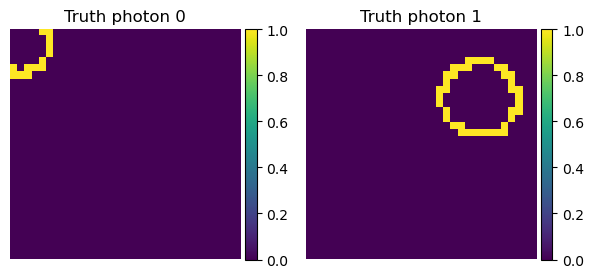

In [141]:
fig, axs = plt.subplots(1,2,figsize=(7,3))

for i,ax in enumerate(axs):

    im = ax.imshow(true[0,i],vmin=0,vmax=1)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax.set_title(f'Truth photon {i}')

    ax.axis('off')

plt.show()

In [144]:
true.shape

torch.Size([4, 2, 32, 32])

In [145]:
k_slots=3
bs,_,nx,ny = true.shape

pred = torch.zeros(bs,k_slots,nx,ny)

In [146]:
pred.shape

torch.Size([4, 3, 32, 32])

In [158]:
shift

dx = np.random.randint(-shift,shift+1,size=bs)
dy = np.random.randint(-shift,shift+1,size=bs)


array([ 0, -1, -1, -1])

In [ ]:
torch.cat()

In [164]:
true[:,:,-1:nx-1,:] #.shape

tensor([], size=(4, 2, 0, 32))

In [154]:
?np.random.randint

In [ ]:
def smear_for_pred(true,k_slots=3):
    '''
    Goal: to setup a prediction that we can test against, just shift the OG image
    '''
    
    pass

In [143]:
true.shape

torch.Size([4, 2, 32, 32])

## New plan


OK, this is great, but I think I can make this even a little bit simpler for debugging!


<img src="attn-2-rings-graphic.png" style="height:250px" align="left" />

In [185]:
true = torch.FloatTensor([[[1,0,0],[0,1,0]],
                          [[0,0,1],[0,1,0]]
                         ])
true.shape

torch.Size([2, 2, 3])

In [187]:
pred = torch.FloatTensor([[[.9,.4,0.],[.1,.1,.1],[0,.6,.9]],
                          [[.9,.3,0.],[.1,.5,.1],[.9,.3,0.]]
                         ])

pred.shape

torch.Size([2, 3, 3])

In [188]:
pred_flat = pred.flatten(0,1) # Shape batch_size * n_slots * pred_dim
pred_flat.shape

torch.Size([6, 3])

`out_prob` should have shape 6, 4, 3

and then we will sum along the last dim and it will have shape 6,4

In [ ]:
# Or, do I want to calculate the ... for each ...

Right before I did this manually with tiling and broadcasting, but I _might_ want to do it manually now?

**Some print statements I had from running the DETR kaggle nb:**

```
pred_logits torch.Size([2, 100, 2])
out_prob torch.Size([2, 100, 2])
v[labels] torch.Size([47])
v[labels] torch.Size([46])
tgt_ids torch.Size([93])
-out_prob[:, tgt_ids] torch.Size([200, 93])
```

- `batch_size` = 2
- `n_queries` = 100
- There are two targets (?) 
    * one has 47 labels  
    * the other has 49 labels
    * Personal guess -- these are the number of truth labels for each of the events in the batch
- Then the final loss over _all_ combinations has shape 200,93
    * Personal guess these two targets _have_ to correspond to the batch size being  


**TO DO:** Shape my data to have this shape :)

- Should have shape (1 * 3, 4)
    * **Step 1:** Do this with my "dummy" batch size of 1
        - out_preds should have shape (1*3, 3) # bs * n_slot, n_dim (?)
        - target should have shape (bs*)
    * **Step 2:** Extend to a _bigger_ batch size 
    
Hmmmm, I'm super not sure lol what to do here(?)

In [178]:
bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class 
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

IndentationError: unexpected indent (1128360448.py, line 4)

In [ ]:
from scipy.optimize import linear_sum_assignment

class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network
    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    
    UNMODIFIED from https://www.kaggle.com/code/virajbagal/pytorch-starter-detection-transformer-train
    
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 1):
        """Creates the matcher
        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0 or cost_giou != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching
        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates
            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

In [ ]:
from scipy.optimize import linear_sum_assignment

class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network
    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    
    MODIFIED from https://www.kaggle.com/code/virajbagal/pytorch-starter-detection-transformer-train
    
    """

    def __init__(self):
        """Creates the matcher
        """
        super().__init__()
        
    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching
        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates
            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class 
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

In [172]:
import torch.nn.functional as F

**Goal:** Check out the `SetCriterion` class to see how they _applied_ these indices to get the final cost.

In [ ]:
class SetCriterion(nn.Module):
    """ This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
        
        MODIFIED from https://www.kaggle.com/code/virajbagal/pytorch-starter-detection-transformer-train    
    """
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        """ Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses

    @torch.no_grad()
    def loss_cardinality(self, outputs, targets, indices, num_boxes):
        """ Compute the cardinality error, ie the absolute error in the number of predicted non-empty boxes
        This is not really a loss, it is intended for logging purposes only. It doesn't propagate gradients
        """
        pred_logits = outputs['pred_logits']
        device = pred_logits.device
        tgt_lengths = torch.as_tensor([len(v["labels"]) for v in targets], device=device)
        # Count the number of predictions that are NOT "no-object" (which is the last class)
        card_pred = (pred_logits.argmax(-1) != pred_logits.shape[-1] - 1).sum(1)
        card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
        losses = {'cardinality_error': card_err}
        return losses

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the bounding boxes, the L1 regression loss and the GIoU loss
           targets dicts must contain the key "boxes" containing a tensor of dim [nb_target_boxes, 4]
           The target boxes are expected in format (center_x, center_y, w, h), normalized by the image size.
        """
        assert 'pred_boxes' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_boxes = outputs['pred_boxes'][idx]
        target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')

        losses = {}
        losses['loss_bbox'] = loss_bbox.sum() / num_boxes

        loss_giou = 1 - torch.diag(generalized_box_iou(
            box_cxcywh_to_xyxy(src_boxes),
            box_cxcywh_to_xyxy(target_boxes)))
        losses['loss_giou'] = loss_giou.sum() / num_boxes
        return losses

    def loss_masks(self, outputs, targets, indices, num_boxes):
        """Compute the losses related to the masks: the focal loss and the dice loss.
           targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)

        src_masks = outputs["pred_masks"]

        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list([t["masks"] for t in targets]).decompose()
        target_masks = target_masks.to(src_masks)

        src_masks = src_masks[src_idx]
        # upsample predictions to the target size
        src_masks = interpolate(src_masks[:, None], size=target_masks.shape[-2:],
                                mode="bilinear", align_corners=False)
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks[tgt_idx].flatten(1)

        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_boxes),
            "loss_dice": dice_loss(src_masks, target_masks, num_boxes),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'cardinality': self.loss_cardinality,
            'boxes': self.loss_boxes,
            'masks': self.loss_masks
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)

    def forward(self, outputs, targets):
        """ This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}

        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
#         if is_dist_avail_and_initialized():
#             torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / 1, min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

OK, from reading through the code, I _think_ I catch the jist!
1. Flatten the batch
2. 
3. Return the indices
4. Resort the predictions to match the loss
5. Match them to derive the min loss over (disjoint) combinations


KISS -- let's assume that I'll always have more predictions than targets.